## Autoencoders Lab - March 2023
##### Marcin Kierczak marcin.kierczak@scilifelab.se

# Visualizing HapMap phase 3 populations

---

**Synopsis**

In this lab, we will use good old-fashioned chip genotyping data from the HapMap project (phase 3). These data come from a number of humans belonging to different ethnic groups/populations. The groups are genetically distinct but, in some cases, closely related and thus somewhat difficult to distinguish. First, we will try to visualize population structure using classical dimensionality reduction techniques (PCA, MDS). Next, we will build an autoencoder model and see whether it does any different (better or worse) in separating different populations. Throughout the entire lab, we will be using Keras interface to TensorFlow.

---

### **Background**

The purpose of this lab is to evaluate the possibility of using autoencoders as a replacement/complement to more mainstream linear dimensionality reduction methods including as PCA or MDS. These are commonly used for, e.g. visualizing population structure in genetics. 

One of our main motivations is that when inferring genomic kinship from a large number of markers M (large enough to capture population structure at fine level), one necessarily introduces correlations between variables, here, genetic markers. This is predominantly due to the linkage disequilibrium, but also due to the large M that, even by pure chance, introduces correlated variables to the data. This correlation structure introduces non-linearity that, in turn, makes the data not-so-well suitable for PCA/MDS. The reason being that both PCA and MDS rely on computing kinship matrix determinants that, for a lot of highly correlated variables, become 0 and prevent us from computing exact solutions (division by zero is undefined).

### **Data** 

Here, the working hypotheses is that by choosing non-linear activation functions, e.g. *ReLU,* one can circumvent the variable correlation problem and use autoencoder approach to reduce the dimensionality by embedding kinship data in a low-dimensional *latent representation space* that, in turn, can be easily visualized. The idea emerged during the EMBL conference Reconstructing the Human Past, Heidelberg 🍺, April 2019, in a number of discussions with Nikolay Oskolkov 👨‍🔬 and other conference participants: 🐿, 🦓 and 🐉. It has been further developed during a number of workshops and courses.

Data comes from the HapMap Phase 3 project. Here, for computational feasibility, we will be using smaller dataset, a subset of the original data. I have pre-selected 5,000 autosomal markers with call rate of 100%. We will not be dealing with missing data here although autoencoders, in contrast to PCA and MDS, can do this which is yet another argument for using them for our purpose.

HapMap 3 populations:

* ASW – African 🌍 ancestry in Southwest USA 🇺🇸
* CEU – Utah residents with Northern and Western European 🌍 ancestry from the CEPH collection
* CHB – Han Chinese in Beijing, China 🇨🇳
* CHD – Chinese 🇨🇳 in Metropolitan Denver, Colorado ⛰
* GIH – Gujarati Indians 🇮🇳 in Houston, Texas
* JPT – Japanese in Tokyo, Japan 🇯🇵
* LWK – Luhya in Webuye, Kenya 🇰🇪
* MEX – Mexican 🇲🇽 ancestry in Los Angeles, California 🐻
* MKK – Maasai in Kinyawa, Kenya 🇰🇪
* TSI – Toscans 🛵 in Italy 🇮🇹
* YRI – Yoruba in Ibadan, Nigeria 🇳🇬

### Step 0 &mdash; getting the data

First, we will download the data from the linked Dropbox account.



In [47]:
#@title Load raw data. Double click to see the code. { display-mode: "form" }

#wget https://www.dropbox.com/s/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
#wget https://www.dropbox.com/s/3lv0062dw20qdqg/autosomal_5k_phenos.csv
#wget https://www.dropbox.com/s/6nzrusxkm536a5j/autosomal_5k_kinship.csv

Now, we will load the data and make sure they look as expected. Note, the genotypes per individual (row) are encoded as the count of minor alleles and thus can take values `gt = {0, 1, 2}`. 

**Q1** How many individuals do we have in the dataset?  
**Q2** How many individuals per population do we have? Do they have the same number of males and females?  


In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

geno = pd.read_csv("~/Dropbox/Public/teaching_materials/datasets/autosomal_5k_matrix.csv", header=0, index_col=0)
pheno = pd.read_csv("~/Dropbox/Public/teaching_materials/datasets/autosomal_5k_phenos.csv", header=0, index_col=0)
kinship = pd.read_csv("~/Dropbox/Public/teaching_materials/datasets/autosomal_5k_kinship.csv", header=0, index_col=0)

print(geno.iloc[0:4, 0:4])
print(pheno.iloc[0:4, 0:4])
print(kinship.iloc[0:4, 0:4])

         rs416967  rs17013842  rs13052452  rs11049986
NA19919         2           1           0           1
NA19916         1           0           0           1
NA19835         0           0           1           1
NA20282         1           1           0           1
              id  sex   FID      dad
NA19919  NA19919    1  2427  NA19908
NA19916  NA19916    1  2431        0
NA19835  NA19835    0  2424        0
NA20282  NA20282    0  2469        0
          NA19919   NA19916   NA19835   NA20282
NA19919  1.000000  0.956045  0.991299  0.998115
NA19916  0.956045  1.000000  0.987325  0.997055
NA19835  0.991299  0.987325  1.000000  0.973136
NA20282  0.998115  0.997055  0.973136  1.000000


In [73]:
pop_dict = {'ASW':'African ancestry in SW USA',
            'CEU':'Utah residents with N and W European ancestry',
            'CHB':'Han Chinese in Beijing China',
            'CHD':'Chinese in Metropolitan Denver Colorado',
            'GIH':'Gujarati Indians in Houston Texas',
            'JPT':'Japanese in Tokyo Japan',
            'LWK':'Luhya in Webuye Kenya',
            'MEX':'Mexican ancestry in Los Angeles California',
            'MKK':'Maasai in Kinyawa Kenya',
            'TSI':'Toscans in Italy',
            'YRI':'Yoruba in Ibadan Nigeria'}
pheno2 = pheno.replace({"population": pop_dict})
pheno2

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA
NA19835,NA19835,0,2424,0,0,0,African ancestry in SW USA
NA20282,NA20282,0,2469,0,0,0,African ancestry in SW USA
NA19703,NA19703,1,2368,0,0,0,African ancestry in SW USA
...,...,...,...,...,...,...,...
NA19119,NA19119,1,Y060,0,0,0,Yoruba in Ibadan Nigeria
NA18860,NA18860,1,Y012,NA18859,NA18858,0,Yoruba in Ibadan Nigeria
NA19207,NA19207,1,Y051,0,0,0,Yoruba in Ibadan Nigeria
NA19103,NA19103,1,Y042,NA19101,NA19102,0,Yoruba in Ibadan Nigeria


In [74]:
# Scaling 
# It will be good to scale our counts data so that it is bound between 0 and 1. 
# Now, the AA homozygotes will be coded as 0, heterozygotes as 0.5 and aa homozygotes as 1. 

geno_data = geno / 2 # Fill in your code here
print(geno_data.iloc[0:7, 0:5])

         rs416967  rs17013842  rs13052452  rs11049986  rs10994341
NA19919       1.0         0.5         0.0         0.5         0.5
NA19916       0.5         0.0         0.0         0.5         0.5
NA19835       0.0         0.0         0.5         0.5         0.0
NA20282       0.5         0.5         0.0         0.5         0.0
NA19703       0.0         0.0         0.0         0.0         0.5
NA19902       0.5         0.5         0.0         1.0         0.0
NA19901       0.5         0.5         0.0         1.0         0.0


In [75]:
# Here, we will generate yet another dataset that is built by introducing some noise into our original data. 
# Now, 0 will encode missing data
import math
import random
noisy_data = (geno + 2)/4
noisy_data = noisy_data.applymap(lambda x: 0 if (random.randint(1, 100) <= 1) else x)
print(noisy_data.iloc[0:5, 0:7]) 

         rs416967  rs17013842  rs13052452  rs11049986  rs10994341  rs1504289  \
NA19919      1.00        0.75        0.50        0.75        0.75       0.50   
NA19916      0.75        0.50        0.50        0.75        0.75       0.50   
NA19835      0.50        0.50        0.75        0.75        0.50       0.75   
NA20282      0.75        0.75        0.50        0.75        0.50       0.50   
NA19703      0.50        0.50        0.50        0.50        0.75       0.75   

         rs882529  
NA19919      0.50  
NA19916      0.75  
NA19835      0.50  
NA20282      0.50  
NA19703      0.50  


In [90]:
train_tensor = geno_data.to_numpy() # Her I do an obviously bad thing -- 
                                    # using all my data to train, not leaving any data for test set
print(type(train_tensor))

# Hyperparameters
hp_loss_fn = 'mse'
hp_act_fn = 'relu'
hp_optimizer = 'adam'
hp_metrics = ['mse','mae','mape']

input_data = keras.Input(shape = train_tensor.shape[1])
output_data = input_data

# Encoder
x = layers.Dense(units = 500, activation = hp_act_fn)(input_data)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.05)(x)
x = layers.Dense(units = 150, activation = hp_act_fn)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.025)(x)
x = layers.Dense(units = 10, activation = hp_act_fn)(x)
x = layers.BatchNormalization()(x)
bottleneck = layers.Dense(units = 2, name='layer_bottleneck')(x)
encoder = keras.Model(input_data, bottleneck, name = 'encoder')
  
# Decoder
x = layers.Dense(units = 10, activation = hp_act_fn)(bottleneck)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.025)(x)
x = layers.Dense(units = 150, activation = hp_act_fn)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(rate = 0.05)(x)
x = layers.Dense(units = 500, activation = hp_act_fn)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(units = train_tensor.shape[1], activation = 'sigmoid')(x)
decoder = keras.Model(bottleneck, x, name = 'decoder')


outputs = decoder(encoder(input_data))
ae = keras.Model(input_data, output_data, name='vanilla_vae')


ae = keras.Model(inputs = input_data, outputs = ae(input_data))
ae.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)
encoder.summary()
decoder.summary()

<class 'numpy.ndarray'>
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 5000)]            0         
                                                                 
 dense_94 (Dense)            (None, 500)               2500500   
                                                                 
 batch_normalization_46 (Bat  (None, 500)              2000      
 chNormalization)                                                
                                                                 
 dropout_45 (Dropout)        (None, 500)               0         
                                                                 
 dense_95 (Dense)            (None, 150)               75150     
                                                                 
 batch_normalization_47 (Bat  (None, 150)              600       
 chNormalization)                  

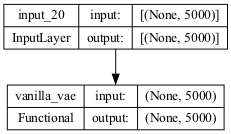

In [97]:
from tensorflow.keras.utils import plot_model
plot_model(ae, show_shapes=True, show_layer_names = True, dpi=70, to_file="autoenc_model.png")

In [98]:
# Set some further hyperparameters
hp_epochs = 30
hp_batch_size = 32
hp_val_split = 0.8

autoencoder = ae.fit(x = train_tensor, 
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split,
                      )

Epoch 1/30
8/8 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - mae: 0.0000e+00 - mape: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_mae: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/30
8/8 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - mae: 0.0000e+00 - mape: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_mae: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 3/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - mae: 0.0000e+00 - mape: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_mae: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 4/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - mae: 0.0000e+00 - mape: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_mae: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 5/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mse: 0.0000

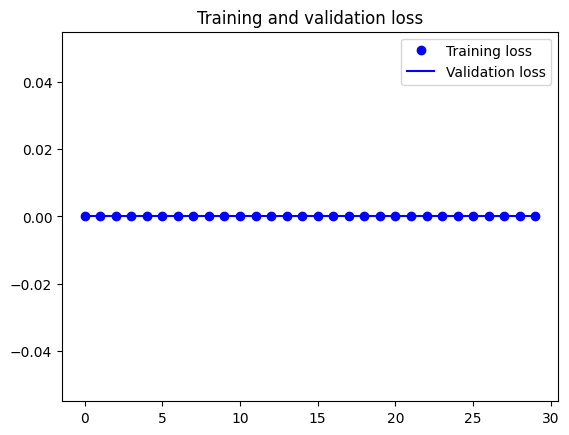

In [96]:
loss = autoencoder.history['loss']
val_loss = autoencoder.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [81]:
# In this step, we will save weights of our trained model into a file
autoencoder_model.save_weights('autoencoder_weights.h5', 
                               overwrite = True)

# Here, we build a new encoder model that we initialize with weights from a file
# QUESTION: why do we need to use skip_mismatch and by_name, both set to True?
encoder_model = keras.Model(inputs = input_data, outputs = Encoder(input_data))
encoder_model.load_weights('autoencoder_weights.h5', 
                           skip_mismatch = True, 
                           by_name = True)

encoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics,
)


37/37 [==============================] - 0s 3ms/step
[[-0.08155907  0.49525893]
 [-0.43198597  0.11240543]
 [-0.31845617  0.15177304]
 ...
 [-0.34875816  0.22089423]
 [-0.08973608  0.24688093]
 [-0.28918386  0.16094714]]


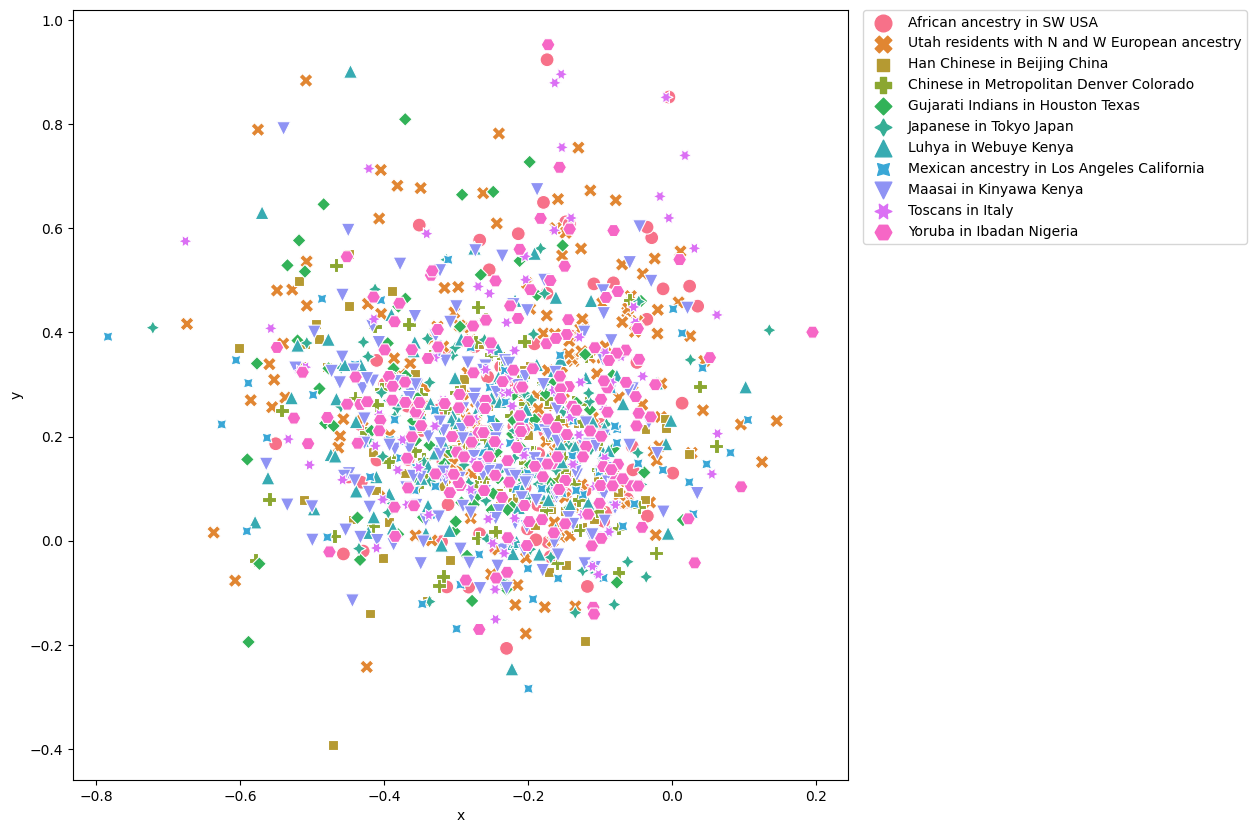

In [70]:
embeded_points =  encoder_model.predict(geno_data.to_numpy()) # Now you need to use the encoder to encode our data points!
print(embeded_points)

x = embeded_points[:,0]
y = embeded_points[:,1]
pop = pheno2['population']
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

In [71]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity = 'precomputed', normalized_stress = 'auto')
mds_embedding = embedding.fit_transform(kinship)


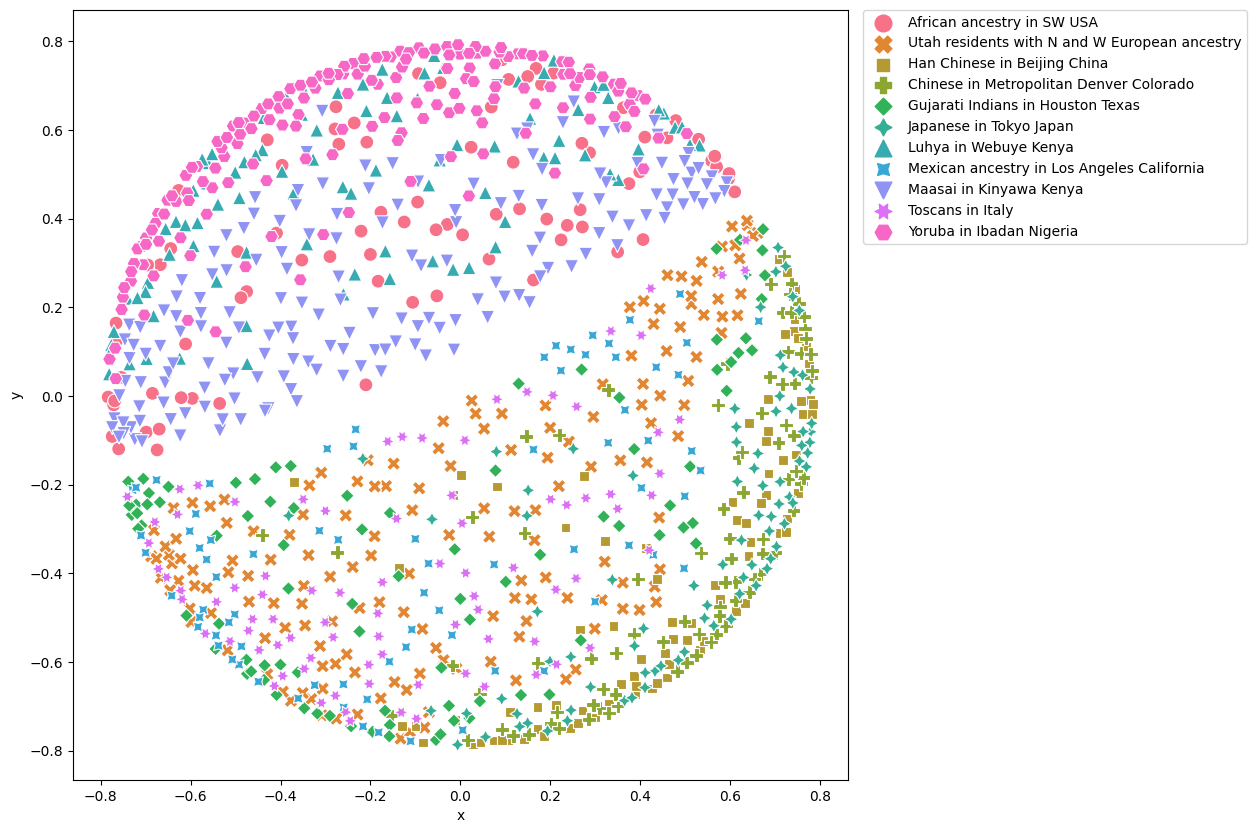

In [43]:
# Below, we visualise results of our MDS 
x = mds_embedding[:,0]
y = mds_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

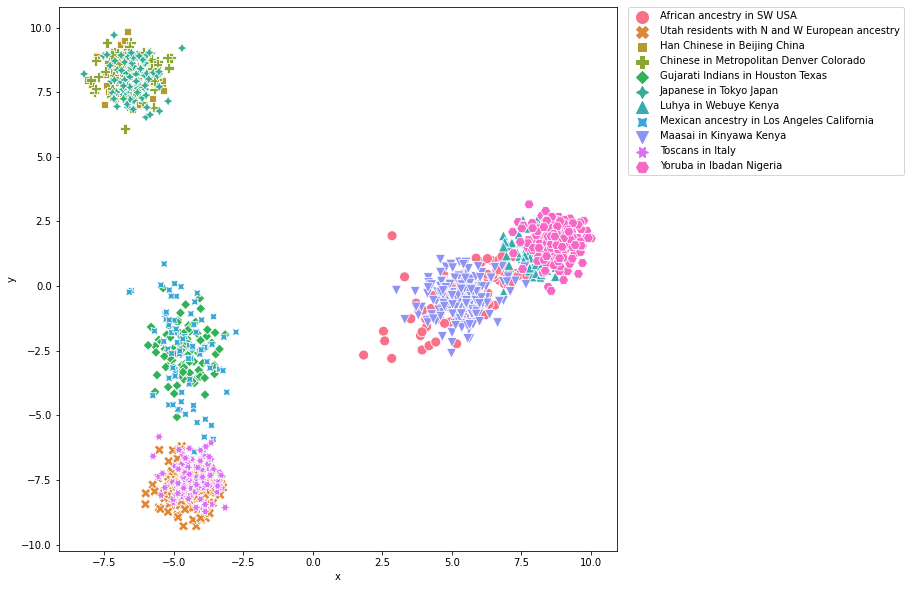

In [ ]:
# And here, we do PCA
from sklearn.decomposition import PCA
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(geno_data * 2)
x = pca_embedding[:,0]
y = pca_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

### Tasks

Now that you have a working example of an autoencoder, try to experiment with your model. Change hyperparameters, e.g. number of layers, size of layers, optimizer, maybe train for a different number of epochs or more dropouts. See whether your new model performs better or worse. If you want, you can have a look at the noisy data.